# Title: Predicting Company Bankruptcy Using Financial Data
# Objective: To analyze financial data to predict the likelihood of company bankruptcy.

In [182]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import scipy.stats as stats
from scipy import stats
from scipy.stats import norm,t


from imblearn.over_sampling import SMOTE
import statsmodels
from statsmodels import stats
from statsmodels.stats import  weightstats

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from statsmodels.stats import proportion

from scipy.stats import chisquare

import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
import pylab
from pylab import plot,show,legend,title,xlabel,ylabel

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [183]:
import os

In [184]:
os.chdir(r'C:\Users\Lenovo\Downloads')

In [185]:
df = pd.read_csv('dataExam.csv')

In [186]:
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.000000e+00,0.458143,7.250725e-04,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,2.559237e-02,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.000000e+00,0.461867,6.470647e-04,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9

In [187]:
df.shape

(6819, 96)

In [188]:
pd.set_option('display.max_columns',300) # This will display maximum 500 Columns
pd.set_option('display.max_rows',300) # This will display maximum 500 Rows

# Rename Columns

In [189]:
df.columns = df.columns.str.replace(' ','')

In [190]:
df.columns = df.columns.str.replace('/','_')

In [191]:
df.columns = df.columns.str.replace('?','')

In [192]:
df.columns = df.columns.str.replace('-','_')

In [193]:
df.columns = df.columns.str.replace('%','_')

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bankrupt                                           6819 non-null   int64  
 1   ROA(C)beforeinterestanddepreciationbeforeinterest  6819 non-null   float64
 2   ROA(A)beforeinterestand_aftertax                   6819 non-null   float64
 3   ROA(B)beforeinterestanddepreciationaftertax        6819 non-null   float64
 4   OperatingGrossMargin                               6819 non-null   float64
 5   RealizedSalesGrossMargin                           6819 non-null   float64
 6   OperatingProfitRate                                6819 non-null   float64
 7   Pre_taxnetInterestRate                             6819 non-null   float64
 8   After_taxnetInterestRate                           6819 non-null   float64
 9   Non_indu

In [195]:
df.shape

(6819, 96)

In [196]:
columns_drop = ['NetIncomeFlag','Liability_AssetsFlag','Bankrupt',]
new_df=df.drop(columns=columns_drop)
#this is catogorical data column that's why we drop 

# To check Outliers

In [197]:
# Function to detect outliers using IQR for all columns
def detect_outliers_iqr(new_df):
    outliers = {}
    for column in new_df.columns:
        if new_df[column].dtype != 'object':  # Ensure the column is numerical
            Q1 = new_df[column].quantile(0.25)
            Q3 = new_df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[column] = new_df[(new_df[column] < lower_bound) | (new_df[column] > upper_bound)]
    return outliers

print("================================================================================")

# Detect outliers in all columns
outliers = detect_outliers_iqr(new_df)

# Print the number of outliers for each feature

count = 0

for feature, outlier_data in outliers.items():
    print(f'{feature}: {len(outlier_data)} outliers')
    if len(outlier_data) > 0:
        count+=1

print("=============================================================================================")
    
# Function to cap outliers for all columns using IQR
def cap_outliers(new_df):
    for column in new_df.columns:
        if new_df[column].dtype != 'object':  # Ensure the column is numerical
            Q1 = new_df[column].quantile(0.25)
            Q3 = new_df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            new_df[column] = np.where(new_df[column] < lower_bound, lower_bound, new_df[column])
            new_df[column] = np.where(new_df[column] > upper_bound, upper_bound, new_df[column])
    return new_df

# Handle outliers in all columns
data_cleaned = cap_outliers(new_df)

# Verify the changes

print("----------------------------------------------------------------------------")

print("Outliers have been capped.")
data_cleaned.describe()

print("------------------------------------------------------------------------------")
print("Outlier Found In : ",count,"  Column")

ROA(C)beforeinterestanddepreciationbeforeinterest: 391 outliers
ROA(A)beforeinterestand_aftertax: 561 outliers
ROA(B)beforeinterestanddepreciationaftertax: 432 outliers
OperatingGrossMargin: 320 outliers
RealizedSalesGrossMargin: 318 outliers
OperatingProfitRate: 716 outliers
Pre_taxnetInterestRate: 773 outliers
After_taxnetInterestRate: 867 outliers
Non_industryincomeandexpenditure_revenue: 1094 outliers
Continuousinterestrate(aftertax): 806 outliers
OperatingExpenseRate: 0 outliers
Researchanddevelopmentexpenserate: 182 outliers
Cashflowrate: 576 outliers
Interest_bearingdebtinterestrate: 396 outliers
Taxrate(A): 120 outliers
NetValuePerShare(B): 457 outliers
NetValuePerShare(A): 464 outliers
NetValuePerShare(C): 465 outliers
PersistentEPSintheLastFourSeasons: 508 outliers
CashFlowPerShare: 532 outliers
RevenuePerShare(Yuan¥): 478 outliers
OperatingProfitPerShare(Yuan¥): 442 outliers
PerShareNetprofitbeforetax(Yuan¥): 511 outliers
RealizedSalesGrossProfitGrowthRate: 814 outliers
Oper

In [198]:
df.shape

(6819, 96)

In [199]:
# Generate descriptive statistics
df.describe()


,Bankrupt,ROA(C)beforeinterestanddepreciationbeforeinterest,ROA(A)beforeinterestand_aftertax,ROA(B)beforeinterestanddepreciationaftertax,OperatingGrossMargin,RealizedSalesGrossMargin,OperatingProfitRate,Pre_taxnetInterestRate,After_taxnetInterestRate,Non_industryincomeandexpenditure_revenue,Continuousinterestrate(aftertax),OperatingExpenseRate,Researchanddevelopmentexpenserate,Cashflowrate,Interest_bearingdebtinterestrate,Taxrate(A),NetValuePerShare(B),NetValuePerShare(A),NetValuePerShare(C),PersistentEPSintheLastFourSeasons,CashFlowPerShare,RevenuePerShare(Yuan¥),OperatingProfitPerShare(Yuan¥),PerShareNetprofitbeforetax(Yuan¥),RealizedSalesGrossProfitGrowthRate,OperatingProfitGrowthRate,After_taxNetProfitGrowthRate,RegularNetProfitGrowthRate,ContinuousNetProfitGrowthRate,TotalAssetGrowthRate,NetValueGrowthRate,TotalAssetReturnGrowthRateRatio,CashReinvestment_,CurrentRatio,QuickRatio,InterestExpenseRatio,Totaldebt_Totalnetworth,Debtratio_,Networth_Assets,Long_termfundsuitabilityratio(A),Borrowingdependency,Contingentliabilities_Networth,Operatingprofit_Paid_incapital,Netprofitbeforetax_Paid_incapital,Inventoryandaccountsreceivable_Netvalue,TotalAssetTurnover,AccountsReceivableTurnover,AverageCollectionDays,InventoryTurnoverRate(times),FixedAssetsTurnoverFrequency,NetWorthTurnoverRate(times),Revenueperperson,Operatingprofitperperson,Allocationrateperperson,WorkingCapitaltoTotalAssets,QuickAssets_TotalAssets,CurrentAssets_TotalAssets,Cash_TotalAssets,QuickAssets_CurrentLiability,Cash_CurrentLiability,CurrentLiabilitytoAssets,OperatingFundstoLiability,Inventory_WorkingCapital,Inventory_CurrentLiability,CurrentLiabilities_Liability,WorkingCapital_Equity,CurrentLiabilities_Equity,Long_termLiabilitytoCurrentAssets,RetainedEarningstoTotalAssets,Totalincome_Totalexpense,Totalexpense_Assets,CurrentAssetTurnoverRate,QuickAssetTurnoverRate,WorkingcapitcalTurnoverRate,CashTurnoverRate,CashFlowtoSales,FixedAssetstoAssets,CurrentLiabilitytoLiability,CurrentLiabilitytoEquity,EquitytoLong_termLiability,CashFlowtoTotalAssets,CashFlowtoLiability,CFOtoAssets,CashFlowtoEquity,CurrentLiabilitytoCurrentAssets,Liability_AssetsFlag,NetIncometoTotalAssets,TotalassetstoGNPprice,No_creditInterval,GrossProfittoSales,NetIncometoStockholder'sEquity,LiabilitytoEquity,DegreeofFinancialLeverage(DFL),InterestCoverageRatio(InterestexpensetoEBIT),NetIncomeFlag,EquitytoLiability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,0.374654,0.005968,0.108977,0.182715,0

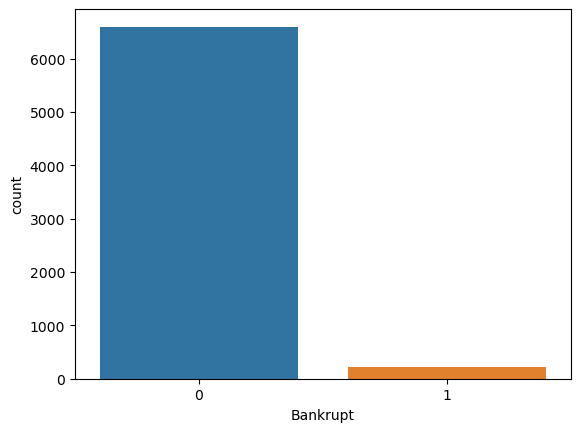

In [200]:
# Plot the distribution of the target variable
sns.countplot(x='Bankrupt', data=df)
plt.show()

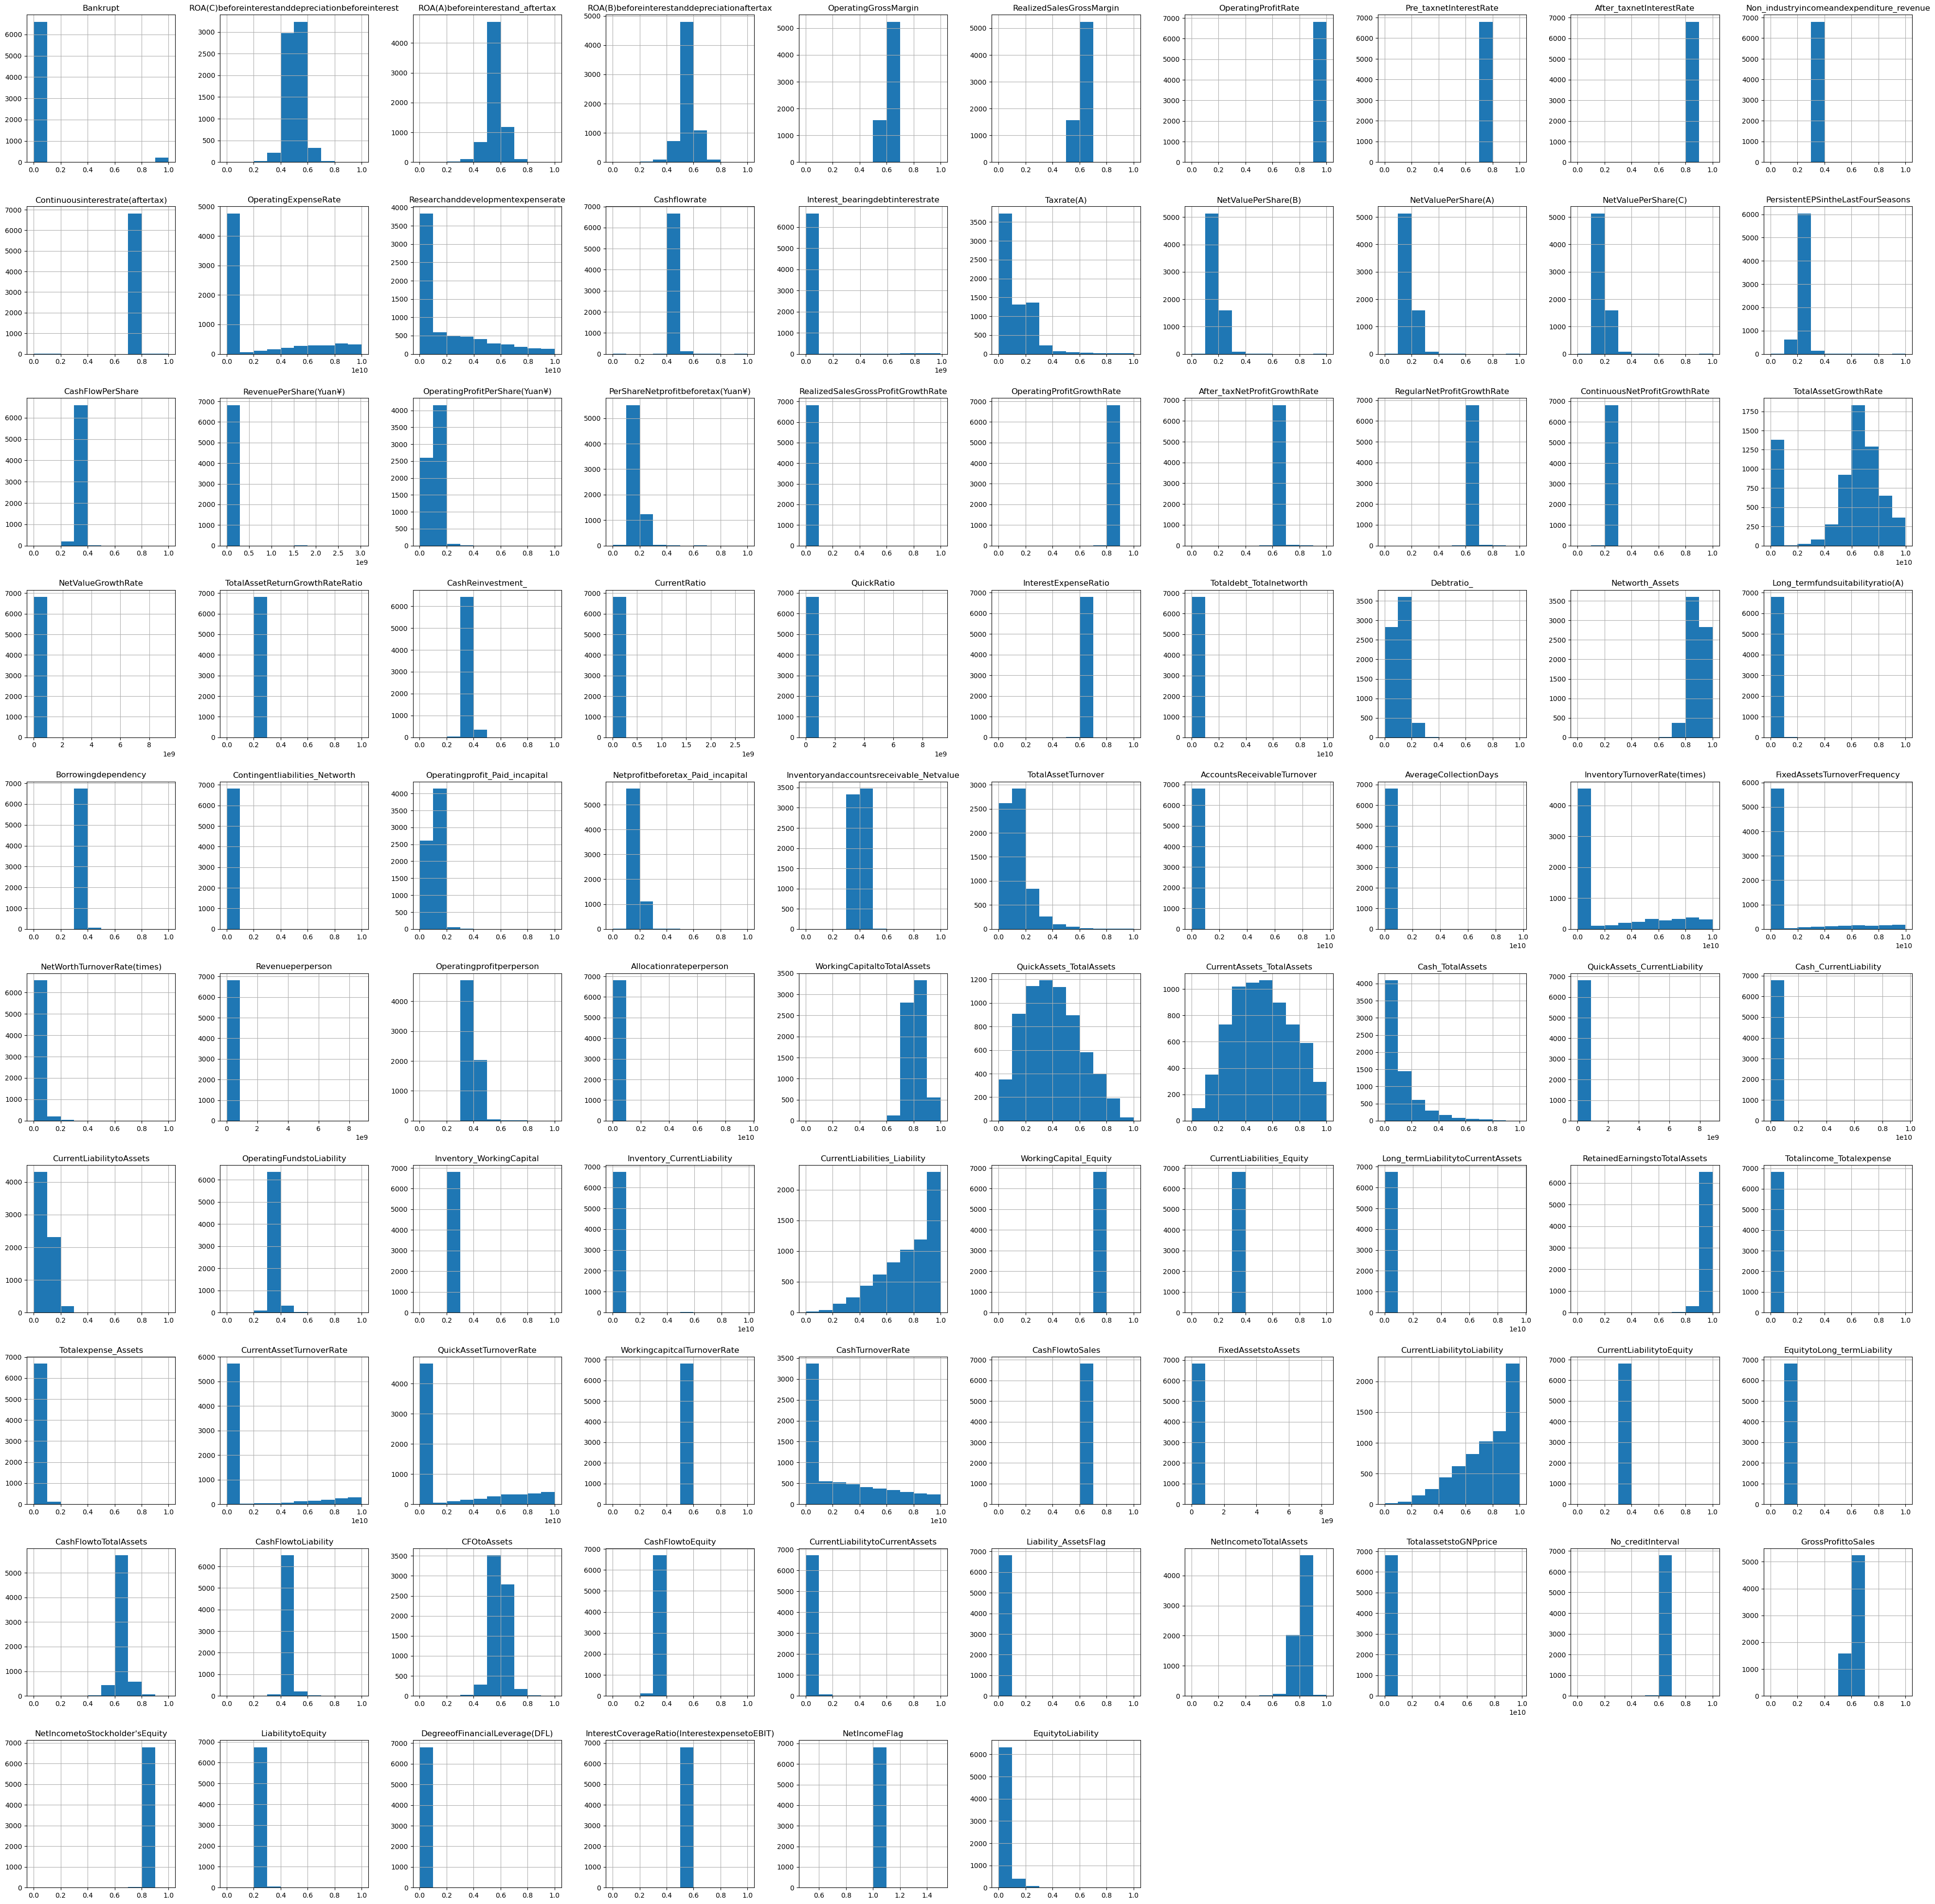

In [201]:
# Plot the distribution of features
df.hist(figsize=(50, 50))
plt.show()

In [220]:
 #we will use correlation matrices and pair plots to analyze relationships.
# Compute the correlation matrix
correlation_matrix = df.corr()


C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


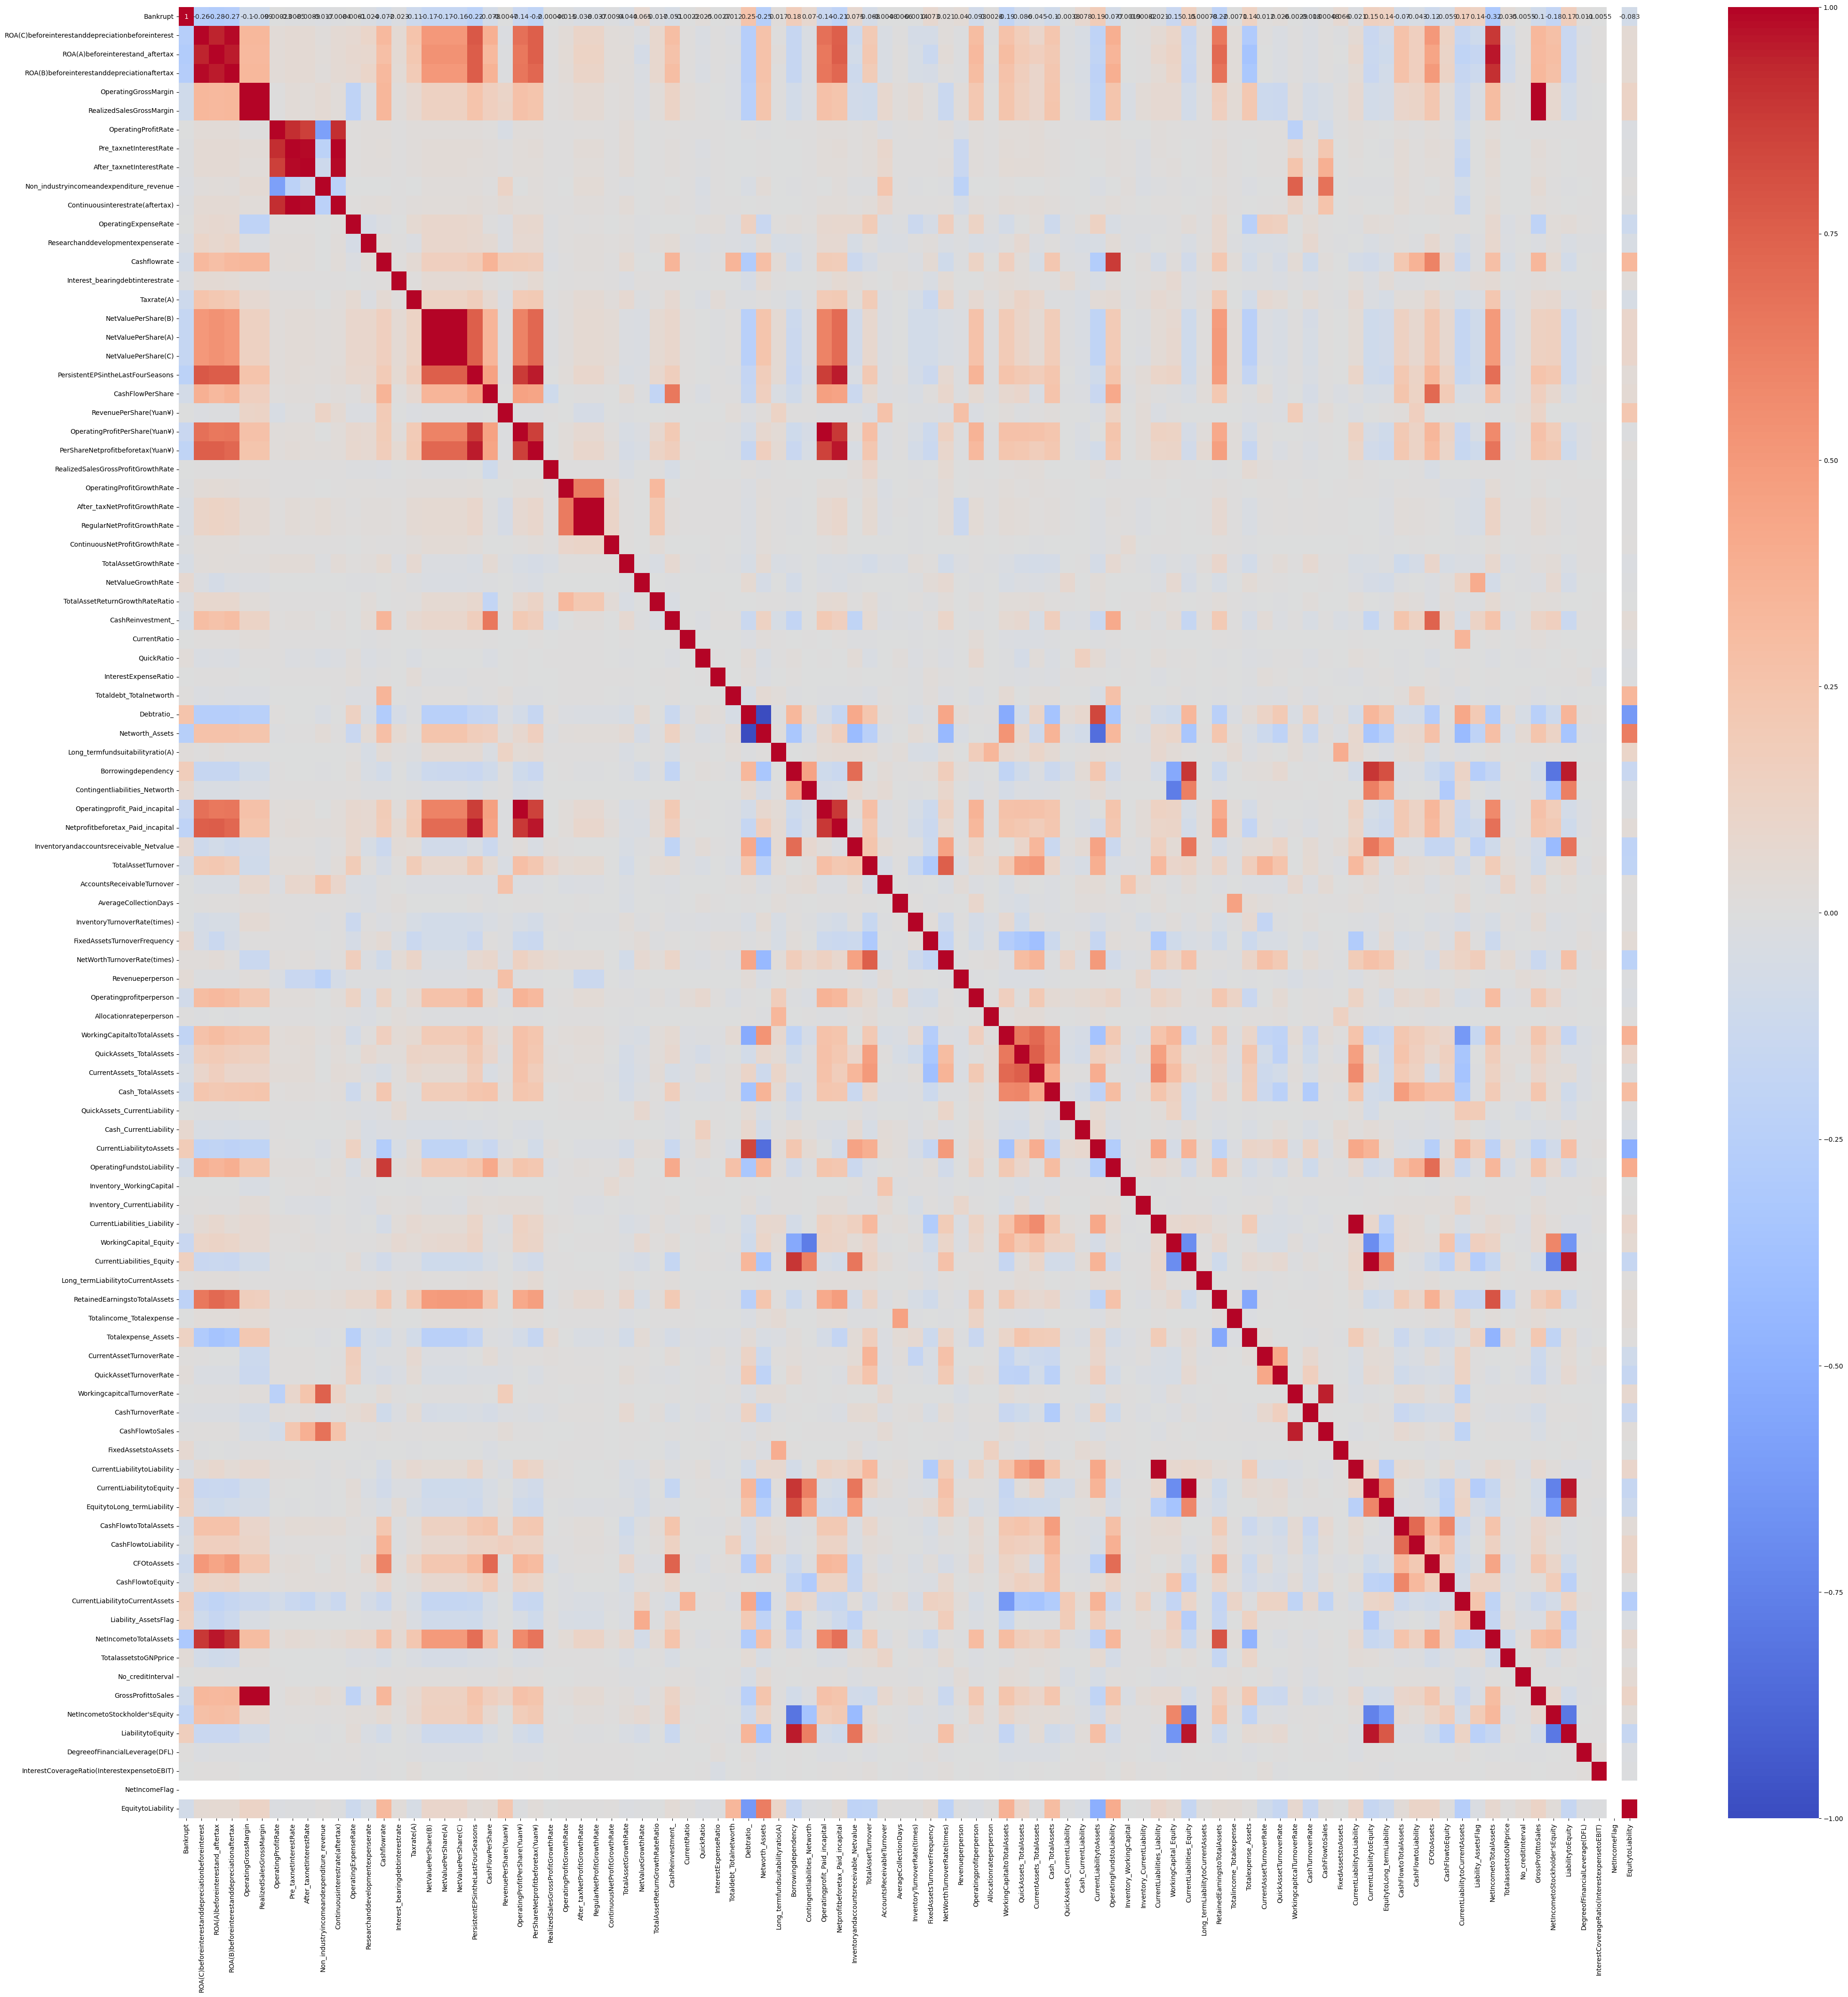

In [204]:
# Plot the heatmap of correlations
plt.figure(figsize=(50, 50))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Hypothesis Testing(T-Test)

In [206]:
# Perform t-tests for each feature
significant_features = []
for column in df.columns[:-1]:  # Exclude the target variable
    t_stat, p_value = scipy.stats.ttest_ind(df[column][df['Bankrupt'] == 1], df[column][df['Bankrupt'] == 0],equal_var=False)
    if p_value < 0.05:
        significant_features.append(column)


C:\Users\Lenovo\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [207]:
print(significant_features)

['Bankrupt', 'ROA(C)beforeinterestanddepreciationbeforeinterest', 'ROA(A)beforeinterestand_aftertax', 'ROA(B)beforeinterestanddepreciationaftertax', 'OperatingGrossMargin', 'RealizedSalesGrossMargin', 'Pre_taxnetInterestRate', 'After_taxnetInterestRate', 'Non_industryincomeandexpenditure_revenue', 'Continuousinterestrate(aftertax)', 'Researchanddevelopmentexpenserate', 'Cashflowrate', 'Interest_bearingdebtinterestrate', 'Taxrate(A)', 'NetValuePerShare(B)', 'NetValuePerShare(A)', 'NetValuePerShare(C)', 'PersistentEPSintheLastFourSeasons', 'CashFlowPerShare', 'RevenuePerShare(Yuan¥)', 'OperatingProfitPerShare(Yuan¥)', 'PerShareNetprofitbeforetax(Yuan¥)', 'After_taxNetProfitGrowthRate', 'RegularNetProfitGrowthRate', 'TotalAssetGrowthRate', 'TotalAssetReturnGrowthRateRatio', 'Debtratio_', 'Networth_Assets', 'Borrowingdependency', 'Operatingprofit_Paid_incapital', 'Netprofitbeforetax_Paid_incapital', 'Inventoryandaccountsreceivable_Netvalue', 'TotalAssetTurnover', 'AverageCollectionDays', '

# RFE: Selected the most relevant features for modeling.

In [209]:
model = LogisticRegression()

rfe = RFE(model, n_features_to_select=10)

rfe = rfe.fit(df.drop('Bankrupt', axis=1), df['Bankrupt'])

selected_features = df.columns[:-1][rfe.support_]
print(selected_features)


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Index(['Cashflowrate', 'CashFlowPerShare', 'TotalAssetGrowthRate',
       'CashReinvestment_', 'TotalAssetTurnover', 'AccountsReceivableTurnover',
       'NetWorthTurnoverRate(times)', 'Operatingprofitperperson',
       'Cash_TotalAssets', 'CashFlowtoSales'],
      dtype='object')


In [215]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df['Bankrupt'], test_size=0.2, random_state=42)



# ModelInterpretation and Insights

In [216]:
# Get the coefficients
coefficients = pd.DataFrame(logistic_model.coef_.T, index=selected_features, columns=['Coefficient'])

# Display the coefficients
print(coefficients.sort_values(by='Coefficient', ascending=False))


ValueError: Shape of passed values is (95, 1), indices imply (10, 1)

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1313
           1       0.05      0.31      0.09        51

    accuracy                           0.75      1364
   macro avg       0.51      0.54      0.47      1364
weighted avg       0.93      0.75      0.83      1364

Accuracy: 0.7536656891495601
[[1012  301]
 [  35   16]]


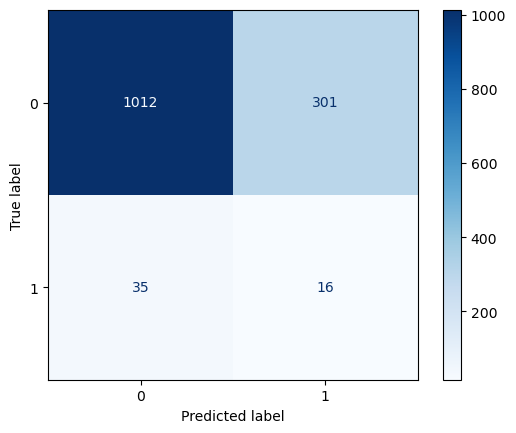

In [217]:



# Evaluate the model
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print(cm)

# Optionally, visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


Key Insights:
Positive Correlations with Bankruptcy Probability:

Borrowing dependency (0.278), Total debt/Total net worth (0.273), Debt ratio % (0.247), and Liability to Equity (0.246) show moderate to strong positive correlations with the likelihood of bankruptcy. This suggests that companies with higher levels of borrowing relative to their assets or equity are more likely to face financial distress leading to bankruptcy.
Negative Correlations:

Retained Earnings to Total Assets (-0.255), Net Income to Total Assets (-0.256), and Persistent EPS in the Last Four Seasons (-0.256) exhibit moderate negative correlations with bankruptcy probability. Companies with higher retained earnings, net income, and persistent earnings per share (EPS) relative to their total assets tend to have lower risks of bankruptcy. These metrics indicate stronger financial health and profitability.
Financial Health Indicators:

Ratios related to profitability (e.g., net income), asset management (e.g., total assets), and financial leverage (e.g., debt ratios) are crucial in assessing bankruptcy risk. Companies should maintain healthy levels of profitability, manage debt effectively, and strengthen asset management practices to mitigate bankruptcy risk.
Implications for Financial Risk Management:
Early Warning Signs:

Monitoring borrowing dependency, debt ratios, and liability to equity ratios can serve as early warning signs of potential financial distress. Financial managers should regularly assess these ratios to identify companies at higher risk of bankruptcy.
Strategic Financial Planning:

Emphasize strategies to reduce borrowing dependency and optimize debt levels relative to assets and equity. This includes refinancing debts at favorable terms, negotiating with creditors, and diversifying funding sources to enhance financial stability.
Profitability and Efficiency:

Focus on improving profitability metrics such as net income and retained earnings. Enhancing operational efficiency and cost management can bolster financial resilience against economic downturns or market volatility.
Scenario Analysis and Stress Testing:

Conduct scenario analyses to evaluate the impact of adverse economic conditions or market shocks on financial ratios. Stress testing helps identify vulnerabilities and prepares contingency plans to mitigate potential risks.
Actionable Recommendations:
Enhance Financial Reporting and Transparency:

Improve transparency in financial reporting to accurately reflect borrowing levels, debt structures, and profitability metrics. Clear and comprehensive financial disclosures facilitate informed decision-making and risk assessment.
Implement Robust Risk Management Practices:

Develop and implement robust risk management frameworks that integrate quantitative analysis of financial ratios with qualitative assessments of market conditions and operational risks.
Invest in Data Analytics and Predictive Modeling:

Leverage advanced data analytics and predictive modeling techniques to enhance bankruptcy prediction capabilities. Develop machine learning models that incorporate significant financial ratios identified through correlation analysis for accurate risk assessment.
Continuous Monitoring and Evaluation:

Establish regular monitoring mechanisms to track changes in key financial ratios and update risk assessments accordingly. Continuous evaluation ensures proactive risk management and timely intervention.